In [1]:
import gzip
import os
import psutil
import subprocess
import time
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Iterator
import multiprocessing as mp

In [2]:
# Path to the directory containing sample_* folders
DATASET_DIR = Path("/home/ctbus/Penn/data/benchmark/reads")
OUTPUT_DIR = Path("/home/ctbus/Penn/data/benchmark/heyfastq")

# File patterns to locate R1 and R2
R1_SUFFIX = "_R1.fastq.gz"
R2_SUFFIX = "_R2.fastq.gz"

In [13]:
datasets = []

for r1 in DATASET_DIR.glob(f"*{R1_SUFFIX}"):
    datasets.append({
        "sample_id": r1.name.replace(R1_SUFFIX, ""),
        "reads": int("".join([c for c in r1.name.replace(R1_SUFFIX, "") if c.isdigit()])),
        "r1": r1,
        "r2": r1.parent / r1.name.replace(R1_SUFFIX, R2_SUFFIX),
        "o1": OUTPUT_DIR / r1.name,
        "o2": OUTPUT_DIR / r1.name.replace(R1_SUFFIX, R2_SUFFIX)
    })

print(datasets)

[{'sample_id': 'sample_10000', 'reads': 10000, 'r1': PosixPath('/home/ctbus/Penn/data/benchmark/reads/sample_10000_R1.fastq.gz'), 'r2': PosixPath('/home/ctbus/Penn/data/benchmark/reads/sample_10000_R2.fastq.gz'), 'o1': PosixPath('/home/ctbus/Penn/data/benchmark/heyfastq/sample_10000_R1.fastq.gz'), 'o2': PosixPath('/home/ctbus/Penn/data/benchmark/heyfastq/sample_10000_R2.fastq.gz')}, {'sample_id': 'sample_100000', 'reads': 100000, 'r1': PosixPath('/home/ctbus/Penn/data/benchmark/reads/sample_100000_R1.fastq.gz'), 'r2': PosixPath('/home/ctbus/Penn/data/benchmark/reads/sample_100000_R2.fastq.gz'), 'o1': PosixPath('/home/ctbus/Penn/data/benchmark/heyfastq/sample_100000_R1.fastq.gz'), 'o2': PosixPath('/home/ctbus/Penn/data/benchmark/heyfastq/sample_100000_R2.fastq.gz')}, {'sample_id': 'sample_1000000', 'reads': 1000000, 'r1': PosixPath('/home/ctbus/Penn/data/benchmark/reads/sample_1000000_R1.fastq.gz'), 'r2': PosixPath('/home/ctbus/Penn/data/benchmark/reads/sample_1000000_R2.fastq.gz'), 'o1

In [4]:
# Remove sample_1000000 for now
datasets = [ds for ds in datasets if ds["sample_id"] != "sample_1000000"]

In [14]:
from pathlib import Path
from typing import Iterator, Tuple
import subprocess
import multiprocessing

def decompress(g: Path, p: int) -> subprocess.Popen:
    return subprocess.Popen(
        ["pigz", "-p", str(p), "-dc", g],
        stdout=subprocess.PIPE,
        text=True,
        bufsize=1
    )

def compress(g: Path, p: int) -> subprocess.Popen:
    return subprocess.Popen(
        ["pigz", "-p", str(p), "-c"],
        stdin=subprocess.PIPE,
        stdout=open(g, "wb"),
        text=True
    )

def read_fastq_records(handle: Iterator[str]) -> Iterator[Tuple[str, str, str, str]]:
    while True:
        try:
            yield tuple([next(handle) for _ in range(4)])
        except StopIteration:
            break

def chunked_records(r1_iter, r2_iter, chunk_size: int):
    """Yield chunks of paired-end records"""
    while True:
        chunk = []
        try:
            for _ in range(chunk_size):
                r1_rec = tuple([next(r1_iter) for _ in range(4)])
                r2_rec = tuple([next(r2_iter) for _ in range(4)])
                chunk.append((r1_rec, r2_rec))
        except StopIteration:
            if chunk:
                yield chunk
            break
        yield chunk

# Your filtering/processing function
def process_chunk(chunk: list[Tuple[Tuple[str, str, str, str], Tuple[str, str, str, str]]]):
    r1_out = []
    r2_out = []
    for r1, r2 in chunk:
        # Example filter: keep all
        keep = True  # Replace with logic
        if keep:
            r1_out.extend(r1)
            r2_out.extend(r2)

    return "".join(r1_out), "".join(r2_out)

import time

def process_paired_fastqs_parallel(
    r1_in: Path, r2_in: Path,
    r1_out: Path, r2_out: Path,
    chunk_size: int = 100,
    p: int = 1,
    q: int = 1,
):
    from multiprocessing import Pool
    print(f"Running with chunk size: {chunk_size}, pigz p: {p}, pool q: {q}")

    # Total stage timers
    total_read_time = 0
    total_filter_time = 0
    total_write_time = 0

    r1_decomp = decompress(r1_in, p)
    r2_decomp = decompress(r2_in, p)
    r1_comp = compress(r1_out, p)
    r2_comp = compress(r2_out, p)

    try:
        r1_iter = iter(r1_decomp.stdout)
        r2_iter = iter(r2_decomp.stdout)

        with Pool(processes=q) as pool:
            for chunk_idx, r1_r2_chunk in enumerate(chunked_records(r1_iter, r2_iter, chunk_size)):

                # 🕐 Time filtering
                t0 = time.perf_counter()
                result_future = pool.apply_async(process_chunk, args=(r1_r2_chunk,))
                filter_result = result_future.get()
                filter_time = time.perf_counter() - t0
                total_filter_time += filter_time

                # 🕐 Time writing
                t1 = time.perf_counter()
                r1_result, r2_result = filter_result
                r1_comp.stdin.write(r1_result)
                r2_comp.stdin.write(r2_result)
                write_time = time.perf_counter() - t1
                total_write_time += write_time

    finally:
        # 🕐 Time reading finalization (decompression pipe close)
        t2 = time.perf_counter()
        r1_decomp.stdout.close()
        r2_decomp.stdout.close()
        r1_comp.stdin.close()
        r2_comp.stdin.close()
        r1_decomp.wait()
        r2_decomp.wait()
        r1_comp.wait()
        r2_comp.wait()
        total_read_time = t2  # Since reading happens in-line during chunk iteration

        print("\n=== Pipeline Stage Timings ===")
        print(f"Total filtering time:   {total_filter_time:.3f} s")
        print(f"Total writing time:     {total_write_time:.3f} s")
        print(f"Total read+prep time:   {total_read_time:.3f} s")
        print("==============================")



In [15]:
results = []

for ds in datasets:
    print(f"Running on {ds['sample_id']}...")

    p = [1, 3, 6, 12]
    q = [1, 3, 6, 12]
    c = [100, 10000, 100000]
    matrix = [(x, y, z) for x in p for y in q for z in c]

    for x, y, z in matrix:
        start_time = time.perf_counter()
        process_paired_fastqs_parallel(
            ds["r1"], ds["r2"],
            ds["o1"], ds["o2"],
            p=x,
            q=y,
            chunk_size=z,
        )

        end_time = time.perf_counter()
        elapsed = end_time - start_time

        res = {
            "sample_id": ds["sample_id"],
            "run_name": f"{x}_{y}_{z}",
            "reads_in": ds["reads"],
            "reads_out": ds["reads"],
            "runtime_sec": elapsed
        }
        print(res)
        results.append(res)

Running on sample_10000...
Running with chunk size: 100, pigz p: 1, pool q: 1



=== Pipeline Stage Timings ===
Total filtering time:   0.157 s
Total writing time:     0.499 s
Total read+prep time:   106684.950 s
{'sample_id': 'sample_10000', 'run_name': '1_1_100', 'reads_in': 10000, 'reads_out': 10000, 'runtime_sec': 0.8675473609910114}
Running with chunk size: 10000, pigz p: 1, pool q: 1

=== Pipeline Stage Timings ===
Total filtering time:   0.244 s
Total writing time:     0.980 s
Total read+prep time:   106686.545 s
{'sample_id': 'sample_10000', 'run_name': '1_1_10000', 'reads_in': 10000, 'reads_out': 10000, 'runtime_sec': 1.5942000740033109}
Running with chunk size: 100000, pigz p: 1, pool q: 1

=== Pipeline Stage Timings ===
Total filtering time:   0.142 s
Total writing time:     0.992 s
Total read+prep time:   106687.879 s
{'sample_id': 'sample_10000', 'run_name': '1_1_100000', 'reads_in': 10000, 'reads_out': 10000, 'runtime_sec': 1.3286672290123533}
Running with chunk size: 100, pigz p: 1, pool q: 3

=== Pipeline Stage Timings ===
Total filtering time:   0

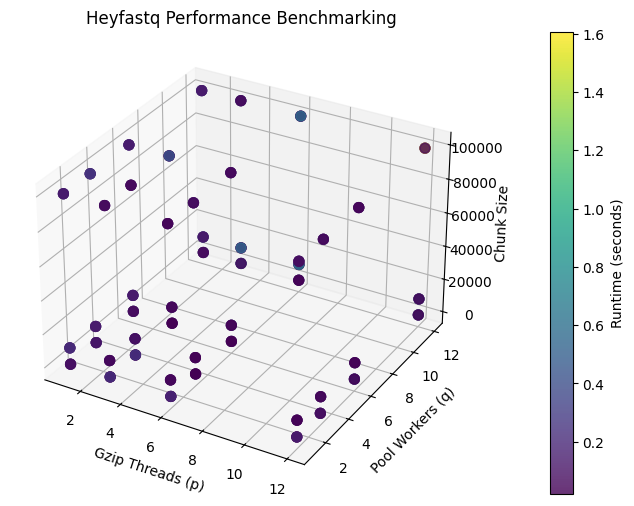

In [21]:
# Plot the results
df = pd.DataFrame(results)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D scatter plot
x = df['run_name'].apply(lambda rn: int(rn.split('_')[0]))  # p values
y = df['run_name'].apply(lambda rn: int(rn.split('_')[1]))  # q values
z = df['run_name'].apply(lambda rn: int(rn.split('_')[2]))  # chunk sizes
# Create color map based on runtime per thousand reads
colors = df['runtime_sec'] / (df['reads_in'] / 1000)
ax.scatter(x, y, z, c=colors, cmap='viridis', s=50, alpha=0.8)

# Set labels and title
ax.set_xlabel('Gzip Threads (p)')
ax.set_ylabel('Pool Workers (q)')
ax.set_zlabel('Chunk Size')
ax.set_title('Heyfastq Performance Benchmarking')
# Include color bar
cbar = plt.colorbar(ax.collections[0], ax=ax, pad=0.1)
cbar.set_label('Runtime (seconds)')

# Display the plot
plt.show()